In [1]:
import os
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
from torchvision.transforms import v2 as T
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix)
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

Sử dụng thiết bị: cuda


In [2]:
class MobileNetV3_AudioClassifier(nn.Module):
    def __init__(self, num_classes, input_channels=1, pretrained=False): # Mặc định pretrained=False
        super().__init__()
        
        weights = models.MobileNet_V3_Large_Weights.DEFAULT if pretrained else None
        self.mobilenet = models.mobilenet_v3_large(weights=weights)

        original_conv = self.mobilenet.features[0][0]
        new_first_conv = nn.Conv2d(
            in_channels=input_channels,
            out_channels=original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=False
        )
        
        self.mobilenet.features[0][0] = new_first_conv

        num_ftrs = self.mobilenet.classifier[-1].in_features
        self.mobilenet.classifier[-1] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.mobilenet(x)

In [3]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

In [4]:
class InsectSpectrogramDataset(Dataset):
    def __init__(self, metadata_file, data_dir, transform=None):
        self.metadata = pd.read_csv(metadata_file)
        self.data_dir = data_dir
        self.transform = transform
        self.file_column = 'file_name'
        self.label_column = 'label'
        
        self.class_names = sorted(self.metadata[self.label_column].unique())
        self.class_to_id = {name: i for i, name in enumerate(self.class_names)}
        self.id_to_class = {i: name for name, i in self.class_to_id.items()}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        file_name = self.metadata.iloc[idx][self.file_column]
        file_path = os.path.join(self.data_dir, file_name)
        label_name = self.metadata.iloc[idx][self.label_column]
        label = self.class_to_id[label_name]
        
        try:
            spectrogram = torch.load(file_path)
            if spectrogram.dim() == 2:
                spectrogram = spectrogram.unsqueeze(0)
            if self.transform:
                spectrogram = self.transform(spectrogram)
            return spectrogram, label
        except Exception as e:
            print(f"Lỗi khi tải file {file_path}: {e}")
            return torch.zeros(1, 128, 259), -1

In [5]:
METADATA_PATH = r'F:\metadata_Mel.csv'
DATA_DIR = r'F:\MelSpectrograms'

In [6]:
class TimeShift(torch.nn.Module):
    def __init__(self, p=0.5, max_shift_percent=0.4):
        super().__init__()
        self.p = p
        self.max_shift_percent = max_shift_percent

    def forward(self, spec):
        if torch.rand(1) < self.p:
            time_steps = spec.shape[-1]
            shift_amount = int(torch.rand(1) * self.max_shift_percent * time_steps)
            if torch.rand(1) < 0.5:
                shift_amount = -shift_amount
            return torch.roll(spec, shifts=shift_amount, dims=-1)
        return spec

class SpecNoise(torch.nn.Module):
    def __init__(self, p=0.5, noise_level=0.05):
        super().__init__()
        self.p = p
        self.noise_level = noise_level

    def forward(self, spec):
        if torch.rand(1) < self.p:
            noise = torch.randn_like(spec) * self.noise_level
            return spec + noise
        return spec

train_transform = T.Compose([
    torchaudio.transforms.TimeMasking(time_mask_param=80),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=25),
    TimeShift(p=0.5, max_shift_percent=0.4),
    SpecNoise(p=0.3, noise_level=0.03),
])

val_transform = None

def mixup_data(x, y, alpha=0.4, use_cuda=True):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device if use_cuda else 'cpu')
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [7]:
if not os.path.exists(METADATA_PATH) or not os.path.isdir(DATA_DIR):
    print("!!! LỖI: Vui lòng kiểm tra lại đường dẫn METADATA_PATH và DATA_DIR.")
else:
    full_dataset = InsectSpectrogramDataset(METADATA_PATH, DATA_DIR)
    num_classes = len(full_dataset.class_names)
    print(f"Tải dữ liệu thành công: {len(full_dataset)} mẫu, {num_classes} lớp.")

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    generator = torch.Generator().manual_seed(42)
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator)

    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform

    BATCH_SIZE = 16
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


Tải dữ liệu thành công: 165982 mẫu, 12 lớp.


In [8]:
EPOCHS = 100
# THAY ĐỔI 2: Tăng learning rate trở lại vì huấn luyện từ đầu
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4

CHECKPOINT_DIR = r'C:\Users\PC\lavar'
LOG_CSV_PATH = r'C:\Users\PC\lavar\training_log_mobilenetv3.csv'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

model = MobileNetV3_AudioClassifier(num_classes=num_classes, pretrained=False).to(device)
total_params, trainable_params = count_parameters(model)
print(f"Khởi tạo mô hình MobileNetV3-Large (từ đầu) với {total_params/1e6:.2f}M tham số.")


Khởi tạo mô hình MobileNetV3-Large (từ đầu) với 4.22M tham số.


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

log_header = ['epoch', 'train_loss', 'val_loss', 'learning_rate', 'accuracy', 'precision', 'recall', 'f1']
with open(LOG_CSV_PATH, 'w', newline='', encoding='utf-8') as f:
    csv.writer(f).writerow(log_header)

print(f"\nBắt đầu huấn luyện... Checkpoints sẽ được lưu tại '{CHECKPOINT_DIR}' và log tại '{LOG_CSV_PATH}'")

best_val_f1 = 0.0
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]")
    for inputs, labels in progress_bar:
        if -1 in labels: continue
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        if torch.rand(1).item() < 0.5:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]"):
            if -1 in labels: continue
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_val_loss   = val_loss / len(val_dataset)
    accuracy  = accuracy_score(val_labels, val_preds)
    precision = precision_score(val_labels, val_preds, average='micro', zero_division=0)
    recall    = recall_score(val_labels, val_preds, average='micro', zero_division=0)
    f1        = f1_score(val_labels, val_preds, average='micro', zero_division=0)
    current_lr = scheduler.get_last_lr()[0]
    scheduler.step()

    print(f"\n--- Epoch {epoch+1}/{EPOCHS} Summary ---")
    print(f"  Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    print(f"  Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

    log_data = [epoch + 1, epoch_train_loss, epoch_val_loss, current_lr, accuracy, precision, recall, f1]
    with open(LOG_CSV_PATH, 'a', newline='', encoding='utf-8') as f:
        csv.writer(f).writerow(log_data)

    if f1 > best_val_f1:
        best_val_f1 = f1
        best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f"  => 🎉 New best model saved to '{best_model_path}' (F1: {best_val_f1:.4f})\n")

print("\n✅ Hoàn tất huấn luyện!")


Bắt đầu huấn luyện... Checkpoints sẽ được lưu tại 'C:\Users\PC\lavar' và log tại 'C:\Users\PC\lavar\training_log_mobilenetv3.csv'


Epoch 1/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 1/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 1/100 Summary ---
  Train Loss: 1.2170 | Val Loss: 2.0675
  Accuracy: 0.4464 | Precision: 0.4464 | Recall: 0.4464 | F1: 0.4464
  => 🎉 New best model saved to 'C:\Users\PC\lavar\best_model.pth' (F1: 0.4464)



Epoch 2/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 2/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 2/100 Summary ---
  Train Loss: 0.9152 | Val Loss: 1.0512
  Accuracy: 0.6165 | Precision: 0.6165 | Recall: 0.6165 | F1: 0.6165
  => 🎉 New best model saved to 'C:\Users\PC\lavar\best_model.pth' (F1: 0.6165)



Epoch 3/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 3/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 3/100 Summary ---
  Train Loss: 0.8230 | Val Loss: 2.8529
  Accuracy: 0.4270 | Precision: 0.4270 | Recall: 0.4270 | F1: 0.4270


Epoch 4/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 4/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 4/100 Summary ---
  Train Loss: 0.7803 | Val Loss: 1.6429
  Accuracy: 0.5664 | Precision: 0.5664 | Recall: 0.5664 | F1: 0.5664


Epoch 5/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 5/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 5/100 Summary ---
  Train Loss: 0.7304 | Val Loss: 1.0122
  Accuracy: 0.6605 | Precision: 0.6605 | Recall: 0.6605 | F1: 0.6605
  => 🎉 New best model saved to 'C:\Users\PC\lavar\best_model.pth' (F1: 0.6605)



Epoch 6/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 6/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 6/100 Summary ---
  Train Loss: 0.6818 | Val Loss: 1.2401
  Accuracy: 0.6163 | Precision: 0.6163 | Recall: 0.6163 | F1: 0.6163


Epoch 7/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 7/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 7/100 Summary ---
  Train Loss: 0.6628 | Val Loss: 0.7640
  Accuracy: 0.7493 | Precision: 0.7493 | Recall: 0.7493 | F1: 0.7493
  => 🎉 New best model saved to 'C:\Users\PC\lavar\best_model.pth' (F1: 0.7493)



Epoch 8/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 8/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 8/100 Summary ---
  Train Loss: 0.6379 | Val Loss: 0.9163
  Accuracy: 0.7186 | Precision: 0.7186 | Recall: 0.7186 | F1: 0.7186


Epoch 9/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 9/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 9/100 Summary ---
  Train Loss: 0.6151 | Val Loss: 0.5484
  Accuracy: 0.8167 | Precision: 0.8167 | Recall: 0.8167 | F1: 0.8167
  => 🎉 New best model saved to 'C:\Users\PC\lavar\best_model.pth' (F1: 0.8167)



Epoch 10/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 10/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 10/100 Summary ---
  Train Loss: 0.6113 | Val Loss: 0.5140
  Accuracy: 0.8255 | Precision: 0.8255 | Recall: 0.8255 | F1: 0.8255
  => 🎉 New best model saved to 'C:\Users\PC\lavar\best_model.pth' (F1: 0.8255)



Epoch 11/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 11/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 11/100 Summary ---
  Train Loss: 0.5850 | Val Loss: 0.4186
  Accuracy: 0.8610 | Precision: 0.8610 | Recall: 0.8610 | F1: 0.8610
  => 🎉 New best model saved to 'C:\Users\PC\lavar\best_model.pth' (F1: 0.8610)



Epoch 12/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 12/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 12/100 Summary ---
  Train Loss: 0.5698 | Val Loss: 0.4156
  Accuracy: 0.8615 | Precision: 0.8615 | Recall: 0.8615 | F1: 0.8615
  => 🎉 New best model saved to 'C:\Users\PC\lavar\best_model.pth' (F1: 0.8615)



Epoch 13/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 13/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 13/100 Summary ---
  Train Loss: 0.5698 | Val Loss: 0.7152
  Accuracy: 0.7673 | Precision: 0.7673 | Recall: 0.7673 | F1: 0.7673


Epoch 14/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 14/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 14/100 Summary ---
  Train Loss: 0.5472 | Val Loss: 0.5693
  Accuracy: 0.8139 | Precision: 0.8139 | Recall: 0.8139 | F1: 0.8139


Epoch 15/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 15/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 15/100 Summary ---
  Train Loss: 0.5390 | Val Loss: 0.5466
  Accuracy: 0.8197 | Precision: 0.8197 | Recall: 0.8197 | F1: 0.8197


Epoch 16/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 16/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 16/100 Summary ---
  Train Loss: 0.5353 | Val Loss: 0.5025
  Accuracy: 0.8412 | Precision: 0.8412 | Recall: 0.8412 | F1: 0.8412


Epoch 17/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 17/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 17/100 Summary ---
  Train Loss: 0.5164 | Val Loss: 0.6295
  Accuracy: 0.7984 | Precision: 0.7984 | Recall: 0.7984 | F1: 0.7984


Epoch 18/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 18/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 18/100 Summary ---
  Train Loss: 0.5190 | Val Loss: 0.3759
  Accuracy: 0.8735 | Precision: 0.8735 | Recall: 0.8735 | F1: 0.8735
  => 🎉 New best model saved to 'C:\Users\PC\lavar\best_model.pth' (F1: 0.8735)



Epoch 19/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 19/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 19/100 Summary ---
  Train Loss: 0.5094 | Val Loss: 1.7739
  Accuracy: 0.5506 | Precision: 0.5506 | Recall: 0.5506 | F1: 0.5506


Epoch 20/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 20/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 20/100 Summary ---
  Train Loss: 0.5065 | Val Loss: 0.4887
  Accuracy: 0.8398 | Precision: 0.8398 | Recall: 0.8398 | F1: 0.8398


Epoch 21/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 21/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 21/100 Summary ---
  Train Loss: 0.4929 | Val Loss: 0.3827
  Accuracy: 0.8712 | Precision: 0.8712 | Recall: 0.8712 | F1: 0.8712


Epoch 22/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 22/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 22/100 Summary ---
  Train Loss: 0.4808 | Val Loss: 0.5038
  Accuracy: 0.8373 | Precision: 0.8373 | Recall: 0.8373 | F1: 0.8373


Epoch 23/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 23/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 23/100 Summary ---
  Train Loss: 0.4813 | Val Loss: 0.5046
  Accuracy: 0.8350 | Precision: 0.8350 | Recall: 0.8350 | F1: 0.8350


Epoch 24/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 24/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 24/100 Summary ---
  Train Loss: 0.4774 | Val Loss: 1.1995
  Accuracy: 0.6719 | Precision: 0.6719 | Recall: 0.6719 | F1: 0.6719


Epoch 25/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 25/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 25/100 Summary ---
  Train Loss: 0.4710 | Val Loss: 0.7089
  Accuracy: 0.7876 | Precision: 0.7876 | Recall: 0.7876 | F1: 0.7876


Epoch 26/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 26/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 26/100 Summary ---
  Train Loss: 0.4562 | Val Loss: 2.1630
  Accuracy: 0.5983 | Precision: 0.5983 | Recall: 0.5983 | F1: 0.5983


Epoch 27/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 27/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 27/100 Summary ---
  Train Loss: 0.4475 | Val Loss: 0.5574
  Accuracy: 0.8208 | Precision: 0.8208 | Recall: 0.8208 | F1: 0.8208


Epoch 28/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 28/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 28/100 Summary ---
  Train Loss: 0.4455 | Val Loss: 0.2858
  Accuracy: 0.9039 | Precision: 0.9039 | Recall: 0.9039 | F1: 0.9039
  => 🎉 New best model saved to 'C:\Users\PC\lavar\best_model.pth' (F1: 0.9039)



Epoch 29/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 29/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 29/100 Summary ---
  Train Loss: 0.4512 | Val Loss: 0.3305
  Accuracy: 0.8935 | Precision: 0.8935 | Recall: 0.8935 | F1: 0.8935


Epoch 30/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 30/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 30/100 Summary ---
  Train Loss: 0.4395 | Val Loss: 1.3784
  Accuracy: 0.6472 | Precision: 0.6472 | Recall: 0.6472 | F1: 0.6472


Epoch 31/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 31/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 31/100 Summary ---
  Train Loss: 0.4295 | Val Loss: 0.9898
  Accuracy: 0.7122 | Precision: 0.7122 | Recall: 0.7122 | F1: 0.7122


Epoch 32/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 32/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 32/100 Summary ---
  Train Loss: 0.4242 | Val Loss: 1.4346
  Accuracy: 0.6461 | Precision: 0.6461 | Recall: 0.6461 | F1: 0.6461


Epoch 33/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 33/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 33/100 Summary ---
  Train Loss: 0.4184 | Val Loss: 0.5038
  Accuracy: 0.8432 | Precision: 0.8432 | Recall: 0.8432 | F1: 0.8432


Epoch 34/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 34/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 34/100 Summary ---
  Train Loss: 0.4126 | Val Loss: 0.6499
  Accuracy: 0.7960 | Precision: 0.7960 | Recall: 0.7960 | F1: 0.7960


Epoch 35/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 35/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 35/100 Summary ---
  Train Loss: 0.4192 | Val Loss: 0.3208
  Accuracy: 0.8942 | Precision: 0.8942 | Recall: 0.8942 | F1: 0.8942


Epoch 36/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 36/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 36/100 Summary ---
  Train Loss: 0.3938 | Val Loss: 0.5422
  Accuracy: 0.8352 | Precision: 0.8352 | Recall: 0.8352 | F1: 0.8352


Epoch 37/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 37/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 37/100 Summary ---
  Train Loss: 0.3970 | Val Loss: 0.9261
  Accuracy: 0.7398 | Precision: 0.7398 | Recall: 0.7398 | F1: 0.7398


Epoch 38/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 38/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 38/100 Summary ---
  Train Loss: 0.3992 | Val Loss: 0.3119
  Accuracy: 0.9024 | Precision: 0.9024 | Recall: 0.9024 | F1: 0.9024


Epoch 39/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 39/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 39/100 Summary ---
  Train Loss: 0.3819 | Val Loss: 0.4303
  Accuracy: 0.8687 | Precision: 0.8687 | Recall: 0.8687 | F1: 0.8687


Epoch 40/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 40/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 40/100 Summary ---
  Train Loss: 0.3929 | Val Loss: 0.5549
  Accuracy: 0.8316 | Precision: 0.8316 | Recall: 0.8316 | F1: 0.8316


Epoch 41/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 41/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 41/100 Summary ---
  Train Loss: 0.3770 | Val Loss: 0.9459
  Accuracy: 0.7502 | Precision: 0.7502 | Recall: 0.7502 | F1: 0.7502


Epoch 42/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 42/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 42/100 Summary ---
  Train Loss: 0.3754 | Val Loss: 0.3107
  Accuracy: 0.9032 | Precision: 0.9032 | Recall: 0.9032 | F1: 0.9032


Epoch 43/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 43/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 43/100 Summary ---
  Train Loss: 0.3765 | Val Loss: 0.3111
  Accuracy: 0.9021 | Precision: 0.9021 | Recall: 0.9021 | F1: 0.9021


Epoch 44/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 44/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 44/100 Summary ---
  Train Loss: 0.3771 | Val Loss: 0.4696
  Accuracy: 0.8594 | Precision: 0.8594 | Recall: 0.8594 | F1: 0.8594


Epoch 45/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 45/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 45/100 Summary ---
  Train Loss: 0.3662 | Val Loss: 0.4626
  Accuracy: 0.8673 | Precision: 0.8673 | Recall: 0.8673 | F1: 0.8673


Epoch 46/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 46/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 46/100 Summary ---
  Train Loss: 0.3717 | Val Loss: 0.4673
  Accuracy: 0.8616 | Precision: 0.8616 | Recall: 0.8616 | F1: 0.8616


Epoch 47/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 47/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 47/100 Summary ---
  Train Loss: 0.3595 | Val Loss: 0.3729
  Accuracy: 0.8857 | Precision: 0.8857 | Recall: 0.8857 | F1: 0.8857


Epoch 48/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 48/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 48/100 Summary ---
  Train Loss: 0.3540 | Val Loss: 0.2717
  Accuracy: 0.9162 | Precision: 0.9162 | Recall: 0.9162 | F1: 0.9162
  => 🎉 New best model saved to 'C:\Users\PC\lavar\best_model.pth' (F1: 0.9162)



Epoch 49/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 49/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 49/100 Summary ---
  Train Loss: 0.3528 | Val Loss: 0.2840
  Accuracy: 0.9132 | Precision: 0.9132 | Recall: 0.9132 | F1: 0.9132


Epoch 50/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 50/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 50/100 Summary ---
  Train Loss: 0.3481 | Val Loss: 0.2806
  Accuracy: 0.9150 | Precision: 0.9150 | Recall: 0.9150 | F1: 0.9150


Epoch 51/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 51/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 51/100 Summary ---
  Train Loss: 0.3420 | Val Loss: 1.1671
  Accuracy: 0.7138 | Precision: 0.7138 | Recall: 0.7138 | F1: 0.7138


Epoch 52/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 52/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 52/100 Summary ---
  Train Loss: 0.3500 | Val Loss: 0.6830
  Accuracy: 0.8175 | Precision: 0.8175 | Recall: 0.8175 | F1: 0.8175


Epoch 53/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 53/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 53/100 Summary ---
  Train Loss: 0.3446 | Val Loss: 0.2822
  Accuracy: 0.9149 | Precision: 0.9149 | Recall: 0.9149 | F1: 0.9149


Epoch 54/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 54/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 54/100 Summary ---
  Train Loss: 0.3333 | Val Loss: 0.3486
  Accuracy: 0.8990 | Precision: 0.8990 | Recall: 0.8990 | F1: 0.8990


Epoch 55/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 55/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 55/100 Summary ---
  Train Loss: 0.3405 | Val Loss: 0.3918
  Accuracy: 0.8861 | Precision: 0.8861 | Recall: 0.8861 | F1: 0.8861


Epoch 56/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 56/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 56/100 Summary ---
  Train Loss: 0.3269 | Val Loss: 0.3803
  Accuracy: 0.8901 | Precision: 0.8901 | Recall: 0.8901 | F1: 0.8901


Epoch 57/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 57/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 57/100 Summary ---
  Train Loss: 0.3332 | Val Loss: 0.2867
  Accuracy: 0.9185 | Precision: 0.9185 | Recall: 0.9185 | F1: 0.9185
  => 🎉 New best model saved to 'C:\Users\PC\lavar\best_model.pth' (F1: 0.9185)



Epoch 58/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 58/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 58/100 Summary ---
  Train Loss: 0.3360 | Val Loss: 0.2913
  Accuracy: 0.9188 | Precision: 0.9188 | Recall: 0.9188 | F1: 0.9188
  => 🎉 New best model saved to 'C:\Users\PC\lavar\best_model.pth' (F1: 0.9188)



Epoch 59/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 59/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 59/100 Summary ---
  Train Loss: 0.3199 | Val Loss: 0.3279
  Accuracy: 0.9094 | Precision: 0.9094 | Recall: 0.9094 | F1: 0.9094


Epoch 60/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 60/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 60/100 Summary ---
  Train Loss: 0.3234 | Val Loss: 0.4292
  Accuracy: 0.8801 | Precision: 0.8801 | Recall: 0.8801 | F1: 0.8801


Epoch 61/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 61/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 61/100 Summary ---
  Train Loss: 0.3117 | Val Loss: 0.3297
  Accuracy: 0.9068 | Precision: 0.9068 | Recall: 0.9068 | F1: 0.9068


Epoch 62/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 62/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 62/100 Summary ---
  Train Loss: 0.3194 | Val Loss: 0.3304
  Accuracy: 0.9100 | Precision: 0.9100 | Recall: 0.9100 | F1: 0.9100


Epoch 63/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 63/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 63/100 Summary ---
  Train Loss: 0.3184 | Val Loss: 0.2910
  Accuracy: 0.9170 | Precision: 0.9170 | Recall: 0.9170 | F1: 0.9170


Epoch 64/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 64/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 64/100 Summary ---
  Train Loss: 0.3121 | Val Loss: 0.2869
  Accuracy: 0.9201 | Precision: 0.9201 | Recall: 0.9201 | F1: 0.9201
  => 🎉 New best model saved to 'C:\Users\PC\lavar\best_model.pth' (F1: 0.9201)



Epoch 65/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 65/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 65/100 Summary ---
  Train Loss: 0.3094 | Val Loss: 0.2904
  Accuracy: 0.9197 | Precision: 0.9197 | Recall: 0.9197 | F1: 0.9197


Epoch 66/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 66/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 66/100 Summary ---
  Train Loss: 0.3140 | Val Loss: 0.3101
  Accuracy: 0.9160 | Precision: 0.9160 | Recall: 0.9160 | F1: 0.9160


Epoch 67/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 67/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 67/100 Summary ---
  Train Loss: 0.3098 | Val Loss: 0.3405
  Accuracy: 0.9063 | Precision: 0.9063 | Recall: 0.9063 | F1: 0.9063


Epoch 68/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 68/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 68/100 Summary ---
  Train Loss: 0.3019 | Val Loss: 0.2883
  Accuracy: 0.9204 | Precision: 0.9204 | Recall: 0.9204 | F1: 0.9204
  => 🎉 New best model saved to 'C:\Users\PC\lavar\best_model.pth' (F1: 0.9204)



Epoch 69/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 69/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 69/100 Summary ---
  Train Loss: 0.3059 | Val Loss: 0.3764
  Accuracy: 0.9000 | Precision: 0.9000 | Recall: 0.9000 | F1: 0.9000


Epoch 70/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 70/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 70/100 Summary ---
  Train Loss: 0.3116 | Val Loss: 0.2894
  Accuracy: 0.9202 | Precision: 0.9202 | Recall: 0.9202 | F1: 0.9202


Epoch 71/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 71/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 71/100 Summary ---
  Train Loss: 0.3039 | Val Loss: 0.3558
  Accuracy: 0.9074 | Precision: 0.9074 | Recall: 0.9074 | F1: 0.9074


Epoch 72/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 72/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 72/100 Summary ---
  Train Loss: 0.2959 | Val Loss: 0.5753
  Accuracy: 0.8532 | Precision: 0.8532 | Recall: 0.8532 | F1: 0.8532


Epoch 73/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 73/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 73/100 Summary ---
  Train Loss: 0.3065 | Val Loss: 0.4099
  Accuracy: 0.8954 | Precision: 0.8954 | Recall: 0.8954 | F1: 0.8954


Epoch 74/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 74/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 74/100 Summary ---
  Train Loss: 0.3089 | Val Loss: 0.5319
  Accuracy: 0.8657 | Precision: 0.8657 | Recall: 0.8657 | F1: 0.8657


Epoch 75/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 75/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 75/100 Summary ---
  Train Loss: 0.3032 | Val Loss: 0.3216
  Accuracy: 0.9139 | Precision: 0.9139 | Recall: 0.9139 | F1: 0.9139


Epoch 76/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 76/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 76/100 Summary ---
  Train Loss: 0.2976 | Val Loss: 0.3295
  Accuracy: 0.9149 | Precision: 0.9149 | Recall: 0.9149 | F1: 0.9149


Epoch 77/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 77/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 77/100 Summary ---
  Train Loss: 0.3017 | Val Loss: 0.3160
  Accuracy: 0.9199 | Precision: 0.9199 | Recall: 0.9199 | F1: 0.9199


Epoch 78/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 78/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 78/100 Summary ---
  Train Loss: 0.3033 | Val Loss: 0.3027
  Accuracy: 0.9213 | Precision: 0.9213 | Recall: 0.9213 | F1: 0.9213
  => 🎉 New best model saved to 'C:\Users\PC\lavar\best_model.pth' (F1: 0.9213)



Epoch 79/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 79/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 79/100 Summary ---
  Train Loss: 0.2977 | Val Loss: 0.3024
  Accuracy: 0.9232 | Precision: 0.9232 | Recall: 0.9232 | F1: 0.9232
  => 🎉 New best model saved to 'C:\Users\PC\lavar\best_model.pth' (F1: 0.9232)



Epoch 80/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 80/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 80/100 Summary ---
  Train Loss: 0.2917 | Val Loss: 0.3255
  Accuracy: 0.9166 | Precision: 0.9166 | Recall: 0.9166 | F1: 0.9166


Epoch 81/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 81/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 81/100 Summary ---
  Train Loss: 0.2961 | Val Loss: 0.2821
  Accuracy: 0.9241 | Precision: 0.9241 | Recall: 0.9241 | F1: 0.9241
  => 🎉 New best model saved to 'C:\Users\PC\lavar\best_model.pth' (F1: 0.9241)



Epoch 82/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 82/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 82/100 Summary ---
  Train Loss: 0.2961 | Val Loss: 0.2953
  Accuracy: 0.9234 | Precision: 0.9234 | Recall: 0.9234 | F1: 0.9234


Epoch 83/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 83/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 83/100 Summary ---
  Train Loss: 0.3033 | Val Loss: 0.5021
  Accuracy: 0.8761 | Precision: 0.8761 | Recall: 0.8761 | F1: 0.8761


Epoch 84/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 84/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 84/100 Summary ---
  Train Loss: 0.2967 | Val Loss: 0.3342
  Accuracy: 0.9165 | Precision: 0.9165 | Recall: 0.9165 | F1: 0.9165


Epoch 85/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 85/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 85/100 Summary ---
  Train Loss: 0.2891 | Val Loss: 0.2994
  Accuracy: 0.9241 | Precision: 0.9241 | Recall: 0.9241 | F1: 0.9241


Epoch 86/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 86/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 86/100 Summary ---
  Train Loss: 0.2857 | Val Loss: 0.3261
  Accuracy: 0.9199 | Precision: 0.9199 | Recall: 0.9199 | F1: 0.9199


Epoch 87/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 87/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 87/100 Summary ---
  Train Loss: 0.2891 | Val Loss: 0.3022
  Accuracy: 0.9243 | Precision: 0.9243 | Recall: 0.9243 | F1: 0.9243
  => 🎉 New best model saved to 'C:\Users\PC\lavar\best_model.pth' (F1: 0.9243)



Epoch 88/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 88/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 88/100 Summary ---
  Train Loss: 0.2872 | Val Loss: 0.2923
  Accuracy: 0.9254 | Precision: 0.9254 | Recall: 0.9254 | F1: 0.9254
  => 🎉 New best model saved to 'C:\Users\PC\lavar\best_model.pth' (F1: 0.9254)



Epoch 89/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 89/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 89/100 Summary ---
  Train Loss: 0.2898 | Val Loss: 0.3082
  Accuracy: 0.9237 | Precision: 0.9237 | Recall: 0.9237 | F1: 0.9237


Epoch 90/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 90/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 90/100 Summary ---
  Train Loss: 0.2915 | Val Loss: 0.5873
  Accuracy: 0.8622 | Precision: 0.8622 | Recall: 0.8622 | F1: 0.8622


Epoch 91/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 91/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 91/100 Summary ---
  Train Loss: 0.2910 | Val Loss: 0.3979
  Accuracy: 0.9018 | Precision: 0.9018 | Recall: 0.9018 | F1: 0.9018


Epoch 92/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 92/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 92/100 Summary ---
  Train Loss: 0.2833 | Val Loss: 0.3069
  Accuracy: 0.9227 | Precision: 0.9227 | Recall: 0.9227 | F1: 0.9227


Epoch 93/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 93/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 93/100 Summary ---
  Train Loss: 0.2887 | Val Loss: 0.3040
  Accuracy: 0.9245 | Precision: 0.9245 | Recall: 0.9245 | F1: 0.9245


Epoch 94/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 94/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 94/100 Summary ---
  Train Loss: 0.2921 | Val Loss: 0.3007
  Accuracy: 0.9248 | Precision: 0.9248 | Recall: 0.9248 | F1: 0.9248


Epoch 95/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 95/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 95/100 Summary ---
  Train Loss: 0.2872 | Val Loss: 0.5190
  Accuracy: 0.8759 | Precision: 0.8759 | Recall: 0.8759 | F1: 0.8759


Epoch 96/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 96/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 96/100 Summary ---
  Train Loss: 0.2830 | Val Loss: 0.3067
  Accuracy: 0.9230 | Precision: 0.9230 | Recall: 0.9230 | F1: 0.9230


Epoch 97/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 97/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 97/100 Summary ---
  Train Loss: 0.2830 | Val Loss: 0.3102
  Accuracy: 0.9230 | Precision: 0.9230 | Recall: 0.9230 | F1: 0.9230


Epoch 98/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 98/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 98/100 Summary ---
  Train Loss: 0.2900 | Val Loss: 0.2964
  Accuracy: 0.9238 | Precision: 0.9238 | Recall: 0.9238 | F1: 0.9238


Epoch 99/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 99/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 99/100 Summary ---
  Train Loss: 0.2900 | Val Loss: 0.3142
  Accuracy: 0.9226 | Precision: 0.9226 | Recall: 0.9226 | F1: 0.9226


Epoch 100/100 [Training]:   0%|          | 0/8300 [00:00<?, ?it/s]

Epoch 100/100 [Validation]:   0%|          | 0/2075 [00:00<?, ?it/s]


--- Epoch 100/100 Summary ---
  Train Loss: 0.2878 | Val Loss: 0.3007
  Accuracy: 0.9240 | Precision: 0.9240 | Recall: 0.9240 | F1: 0.9240

✅ Hoàn tất huấn luyện!


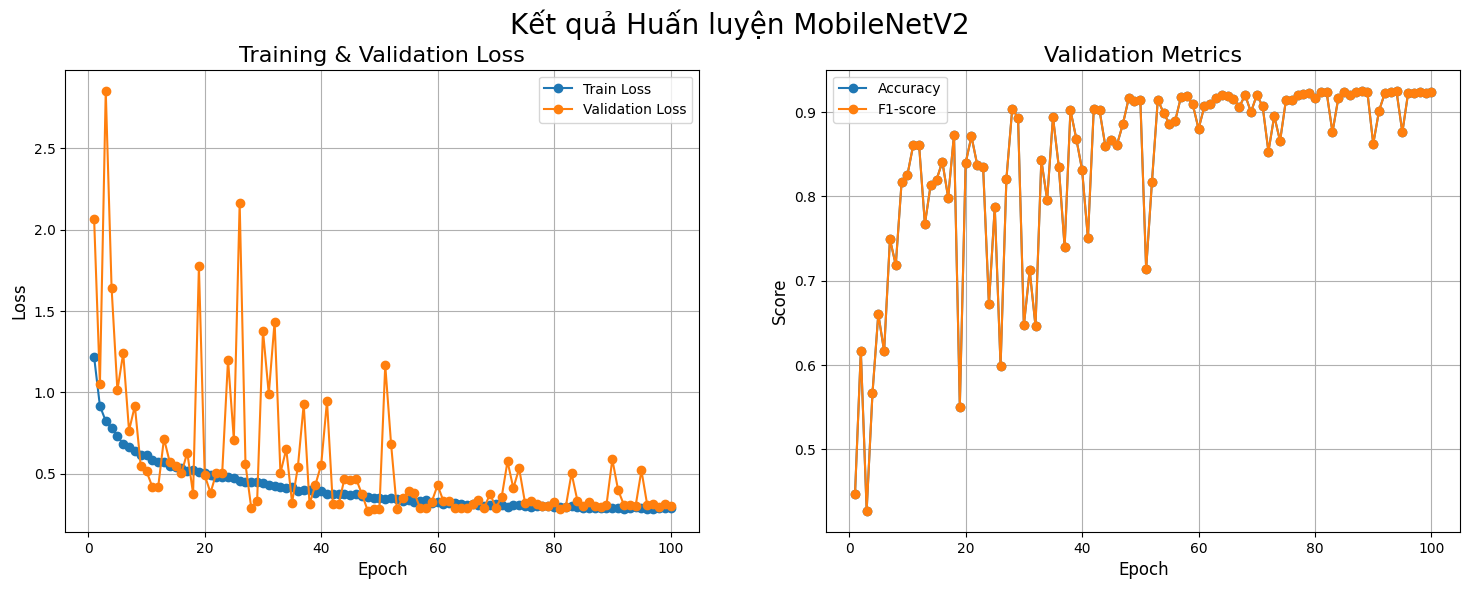


Tải trọng số model tốt nhất để vẽ Confusion Matrix.


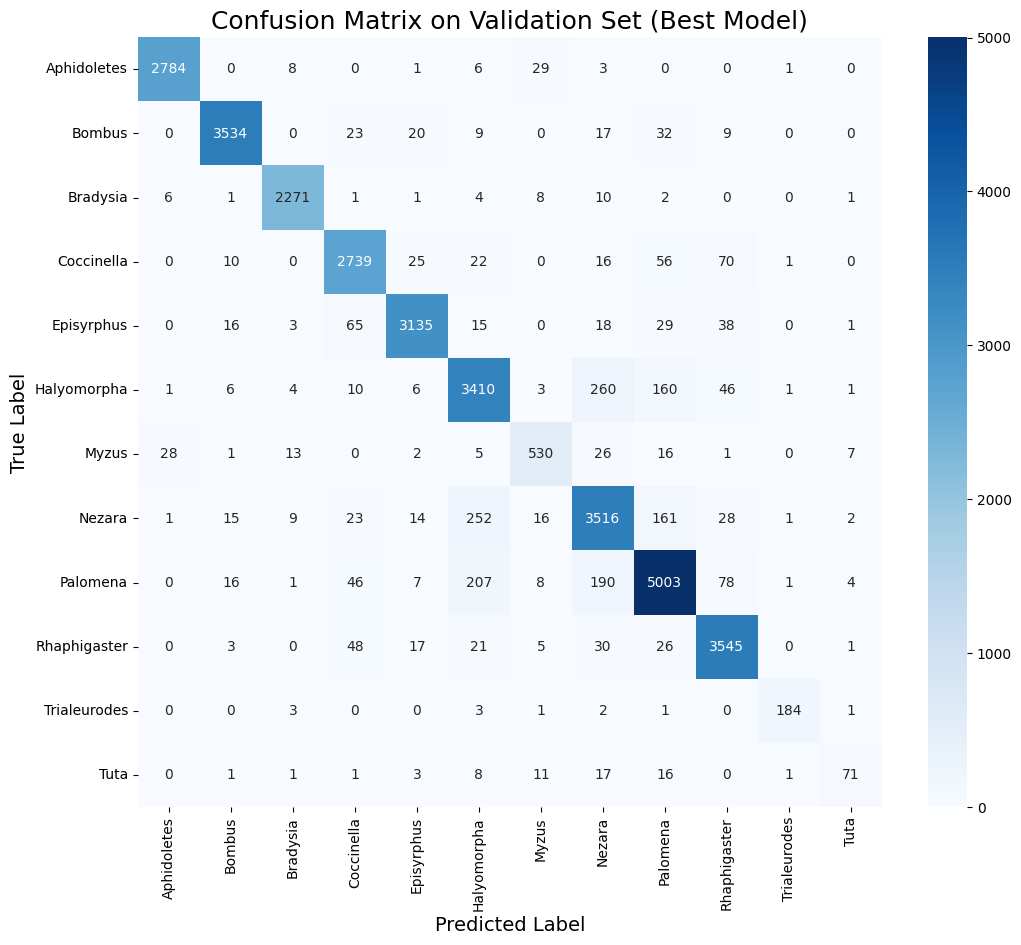

In [10]:
log_df = pd.read_csv(LOG_CSV_PATH)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(log_df['epoch'], log_df['train_loss'], label='Train Loss', marker='o')
ax1.plot(log_df['epoch'], log_df['val_loss'], label='Validation Loss', marker='o')
ax1.set_title('Training & Validation Loss', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()
ax1.grid(True)

ax2.plot(log_df['epoch'], log_df['accuracy'], label='Accuracy', marker='o')
ax2.plot(log_df['epoch'], log_df['f1'], label='F1-score', marker='o')
ax2.set_title('Validation Metrics', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.legend()
ax2.grid(True)

plt.suptitle('Kết quả Huấn luyện MobileNetV2', fontsize=20)
plt.show()

best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("\nTải trọng số model tốt nhất để vẽ Confusion Matrix.")

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        if -1 in labels: continue
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_dataset.class_names,
            yticklabels=full_dataset.class_names)
plt.title('Confusion Matrix on Validation Set (Best Model)', fontsize=18)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()

In [11]:

# === Helpers: schedulers, AMP train, EMA-eval, metrics (no sklearn) ===
import math, torch
from torch import nn
from torch.cuda.amp import autocast, GradScaler

try:
    from torch_ema import ExponentialMovingAverage
except Exception:
    ExponentialMovingAverage = None

def make_ce_loss(label_smoothing: float = 0.1):
    return nn.CrossEntropyLoss(label_smoothing=label_smoothing)

def make_warmup_cosine_scheduler(optimizer, warmup_epochs: int, total_epochs: int, min_lr: float = 1e-6):
    base_lr = optimizer.param_groups[0]["lr"]
    def lr_lambda(epoch: int):
        if epoch < warmup_epochs:
            return (epoch + 1) / max(1, warmup_epochs)
        progress = (epoch - warmup_epochs) / max(1, total_epochs - warmup_epochs)
        # cosine from 1.0 to min_lr/base_lr
        return (min_lr / base_lr) + 0.5 * (1 - (min_lr / base_lr)) * (1 + math.cos(math.pi * progress))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

@torch.no_grad()
def eval_with_metrics(model, val_loader, device, criterion, ema_obj=None, num_classes=None):
    was_train = model.training
    model.eval()
    # Swap EMA weights if available
    if ema_obj is not None and hasattr(ema_obj, "store") and hasattr(ema_obj, "copy_to"):
        ema_obj.store(); ema_obj.copy_to()

    total_loss, total, correct = 0.0, 0, 0
    # per-class confusion for macro metrics
    if num_classes is None:
        # try to infer from last linear
        try:
            num_classes = model.mobilenet.classifier[-1].out_features
        except Exception:
            num_classes = 2
    tp = torch.zeros(num_classes, dtype=torch.long, device="cpu")
    fp = torch.zeros(num_classes, dtype=torch.long, device="cpu")
    fn = torch.zeros(num_classes, dtype=torch.long, device="cpu")
    support = torch.zeros(num_classes, dtype=torch.long, device="cpu")

    for x, y in val_loader:
        x = x.to(device, non_blocking=True); y = y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += float(loss.item()) * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)
        # update per-class stats
        for c in range(num_classes):
            yc = (y == c)
            pc = (pred == c)
            tp[c] += (yc & pc).sum().item()
            fp[c] += ((~yc) & pc).sum().item()
            fn[c] += (yc & (~pc)).sum().item()
            support[c] += yc.sum().item()

    if ema_obj is not None and hasattr(ema_obj, "restore"):
        ema_obj.restore()
    if was_train:
        model.train()

    acc = correct / max(1, total)
    # macro precision/recall/f1 (avoid div by zero)
    precision_c = tp.float() / torch.clamp(tp.float() + fp.float(), min=1.0)
    recall_c = tp.float() / torch.clamp(tp.float() + fn.float(), min=1.0)
    f1_c = 2 * precision_c * recall_c / torch.clamp(precision_c + recall_c, min=1e-8)
    precision = precision_c.mean().item()
    recall = recall_c.mean().item()
    f1 = f1_c.mean().item()

    return (total_loss / max(1, total)), {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

def train_epoch_amp(model, train_loader, device, optimizer, criterion, scaler, max_grad_norm=1.0):
    model.train()
    total_loss = 0.0
    for x, y in train_loader:
        x = x.to(device, non_blocking=True); y = y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=(device.type == "cuda")):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        if max_grad_norm is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        scaler.step(optimizer)
        scaler.update()
        total_loss += float(loss.item()) * x.size(0)
    return total_loss / len(train_loader.dataset)


In [ ]:

# === Improved training loop (Warmup+Cosine, AMP, Gradient Clipping, EMA, Label Smoothing) ===
import os, csv, torch
from time import time

# Hyper-params (reuse your EPOCHS/LEARNING_RATE/WEIGHT_DECAY if already set above)
WARMUP_EPOCHS = 5
MIN_LR = 1e-6

# Loss, optimizer, scheduler
criterion = make_ce_loss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = make_warmup_cosine_scheduler(optimizer, warmup_epochs=WARMUP_EPOCHS, total_epochs=EPOCHS, min_lr=MIN_LR)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))

# EMA (optional)
ema = None
if ExponentialMovingAverage is not None:
    ema = ExponentialMovingAverage(model.parameters(), decay=0.999)

# Prepare CSV
log_header = ['epoch', 'train_loss', 'val_loss', 'learning_rate', 'accuracy', 'precision', 'recall', 'f1']
with open(LOG_CSV_PATH, 'w', newline='', encoding='utf-8') as f:
    csv.writer(f).writerow(log_header)

best_val_f1 = 0.0
print(f"\nBắt đầu huấn luyện (improved)... Checkpoints: '{CHECKPOINT_DIR}', log: '{LOG_CSV_PATH}'")

for epoch in range(EPOCHS):
    t0 = time()
    # Train
    train_loss = train_epoch_amp(model, train_loader, device, optimizer, criterion, scaler, max_grad_norm=1.0)
    # Step LR (LambdaLR expects step() per epoch)
    scheduler.step()

    # Validate (with EMA swap if available)
    val_loss, metrics = eval_with_metrics(model, val_loader, device, criterion, ema_obj=ema)
    acc = metrics['accuracy']; precision = metrics['precision']; recall = metrics['recall']; f1 = metrics['f1']

    current_lr = optimizer.param_groups[0]['lr']
    print(f"\n--- Epoch {epoch+1}/{EPOCHS} Summary ---")
    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"  Accuracy: {acc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
    print(f"  LR: {current_lr:.6f} | Thời gian: {time()-t0:.1f}s")

    with open(LOG_CSV_PATH, 'a', newline='', encoding='utf-8') as f:
        csv.writer(f).writerow([epoch+1, train_loss, val_loss, current_lr, acc, precision, recall, f1])

    if f1 > best_val_f1:
        best_val_f1 = f1
        best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f"  => 🎉 New best model saved to '{best_model_path}' (F1: {best_val_f1:.4f})\n")

print("\n✅ Hoàn tất huấn luyện (improved)!")


C:\Users\PC\AppData\Local\Temp\ipykernel_20116\344254410.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))
C:\Users\PC\AppData\Local\Temp\ipykernel_20116\2647448223.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):



Bắt đầu huấn luyện (improved)... Checkpoints: 'C:\Users\PC\lavar', log: 'C:\Users\PC\lavar\training_log_mobilenetv3.csv'
